# Black–Scholes PDE, Explicit FDM, Crank–Nicolson, Greeks, Error Analysis

## Black–Scholes PDE

The Black–Scholes PDE contains four terms:

1. Time decay term:

$
\frac{\partial V}{\partial t}
$

2. Diffusion term:

$
\frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}
$

3. Drift term:

$
r S \frac{\partial V}{\partial S}
$

4. Discount term:

$
- rV
$

Putting them together, the full PDE is:

$
\frac{\partial V}{\partial t}
+ \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}
+ r S \frac{\partial V}{\partial S}
- rV = 0.
$

---

## Final condition (European call)

$
V(S,T) = \max(S - K, 0).
$

---

## Boundary conditions

Lower boundary:

$
V(0,t) = 0.
$

Upper boundary:

$
V(S_{\max}, t) \approx S_{\max} - K e^{-r (T - t)}.
$

---

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import solve_banded

In [3]:
# Closed-form Black-Scholes for a European Call

def bs_call_price(S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def bs_call_delta(S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)

def bs_call_gamma(S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    return norm.pdf(d1) / (S*sigma*np.sqrt(T))



## Explicit Finite Difference Method

We discretize:

Asset grid:

$

S_i = i\,\Delta S, \quad i = 0,1,\ldots,M

$

Time grid:

$
t_n = n\,\Delta t, \quad n = 0,1,\ldots,N
$

Finite difference approximations:

Time derivative:

$
V_t \approx \frac{V_i^{n+1} - V_i^{n}}{\Delta t}
$

First derivative in S:

$
V_S \approx \frac{V_{i+1}^{n} - V_{i-1}^{n}}{2\Delta S}
$

Second derivative in S:

$
V_{SS} \approx \frac{V_{i+1}^{n} - 2V_i^{n} + V_{i-1}^{n}}{(\Delta S)^2}
$

Explicit update formula:

$
V_i^{n}
=
a_i V_{i-1}^{n+1}
+
b_i V_i^{n+1}
+
c_i V_{i+1}^{n+1}
$

where coefficients are:

$
a_i = \tfrac12 \Delta t (\sigma^2 i^2 - r i)
$

$
b_i = 1 - \Delta t(\sigma^2 i^2 + r)
$

$
c_i = \tfrac12 \Delta t(\sigma^2 i^2 + r i)
$

---

In [7]:
# Explicit Finite Difference Scheme

def explicit_fdm_call(Smax, K, r, sigma, T, M, N):
    dt = T / N
    dS = Smax / M

    # grid
    grid = np.zeros((N+1, M+1))
    S = np.linspace(0, Smax, M+1)

    # terminal payoff
    grid[-1] = np.maximum(S-K, 0)

    # boundary at S=0: always 0
    # boundary at S=Smax: behaves like S - discounted K
    for n in reversed(range(N)):
        t = n*dt
        grid[n, M] = Smax - K*np.exp(-r*(T-t))

        for i in range(1, M):
            a = 0.5*dt*(sigma**2 * i**2 - r*i)
            b = 1 - dt*(sigma**2*i**2 + r)
            c = 0.5*dt*(sigma**2 * i**2 + r*i)
            grid[n, i] = a*grid[n+1, i-1] + b*grid[n+1, i] + c*grid[n+1, i+1]

    return S, grid[0]

## Crank–Nicolson Method

Crank–Nicolson averages explicit and implicit schemes:

$
\frac{V_i^{n+1} - V_i^{n}}{\Delta t}
=
\frac12 \left( L V^{n+1} + L V^{n} \right)
$

This creates a tridiagonal system:

$
A V^{n} = B V^{n+1}
$

Crank–Nicolson is unconditionally stable and second–order accurate.

---

## Greeks from the PDE Grid

Delta:

$
\Delta(S_i)
=
\frac{V_{i+1} - V_{i-1}}{2\Delta S}
$

Gamma:

$
\Gamma(S_i)
=
\frac{V_{i+1} - 2V_i + V_{i-1}}{(\Delta S)^2}
$

---

## Error Analysis

Numerical vs closed-form Black–Scholes:

$
\text{Error}(S)
=
V_{\text{num}}(S) - V_{\text{BS}}(S)
$

---

In [8]:
# Crank–Nicolson Finite Difference

def crank_nicolson_call(Smax, K, r, sigma, T, M, N):
    dt = T/N
    dS = Smax/M
    S = np.linspace(0, Smax, M+1)

    # payoff at maturity
    V = np.maximum(S - K, 0)

    # coefficients
    i_vals = np.arange(1, M)
    alpha = 0.25*dt*(sigma**2 * i_vals**2 - r*i_vals)
    beta  = -0.5*dt*(sigma**2 * i_vals**2 + r)
    gamma = 0.25*dt*(sigma**2 * i_vals**2 + r*i_vals)

    # matrix bands for solving
    A = np.zeros((3, M-1))
    B = np.zeros((3, M-1))

    # A is implicit (LHS)
    A[0,1:] = -alpha[1:]
    A[1,:] = 1 - beta
    A[2,:-1] = -gamma[:-1]

    # B is explicit (RHS)
    B[0,1:] = alpha[1:]
    B[1,:] = 1 + beta
    B[2,:-1] = gamma[:-1]

    for n in range(N):
        rhs = B[0]*V[:-2] + B[1]*V[1:-1] + B[2]*V[2:]
        
        # boundary conditions
        rhs[0]   += alpha[0]*0
        rhs[-1] += gamma[-1] * (Smax - K*np.exp(-r*(T - n*dt)))

        V[1:-1] = solve_banded((1,1), A, rhs)

    return S, V

In [11]:
# Run both solvers & comparison

Smax = 200
K = 100
r = 0.05
sigma = 0.2
T = 1

M = 200
N = 2000

S_exp, V_exp = explicit_fdm_call(Smax, K, r, sigma, T, M, N)
S_cn, V_cn = crank_nicolson_call(Smax, K, r, sigma, T, M, N)

# Analytical
S_vals = np.linspace(1e-6, Smax, 500)
analytic = bs_call_price(S_vals, K, r, sigma, T)

# Interpolate numerical results
V_exp_interp = np.interp(S_vals, S_exp, V_exp)
V_cn_interp = np.interp(S_vals, S_cn, V_cn)

# Greeks (from CN for stability)
delta = np.gradient(V_cn, S_cn)
gamma = np.gradient(delta, S_cn)

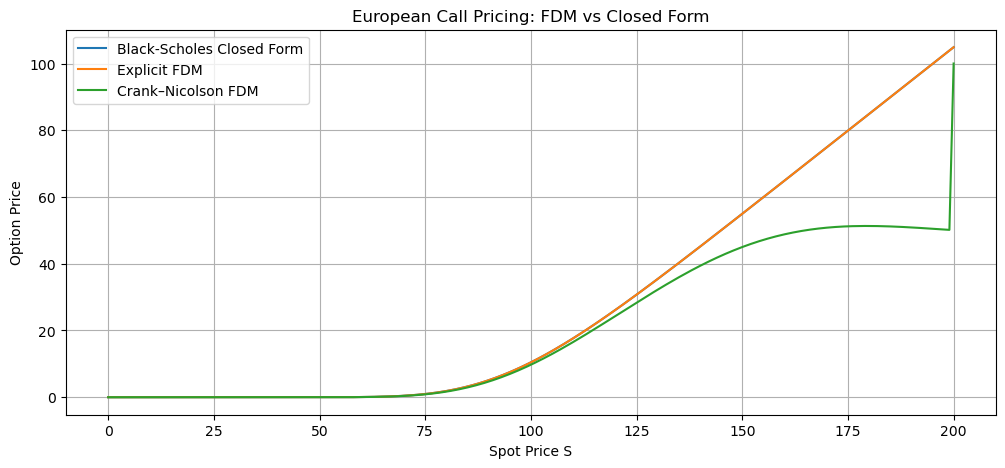

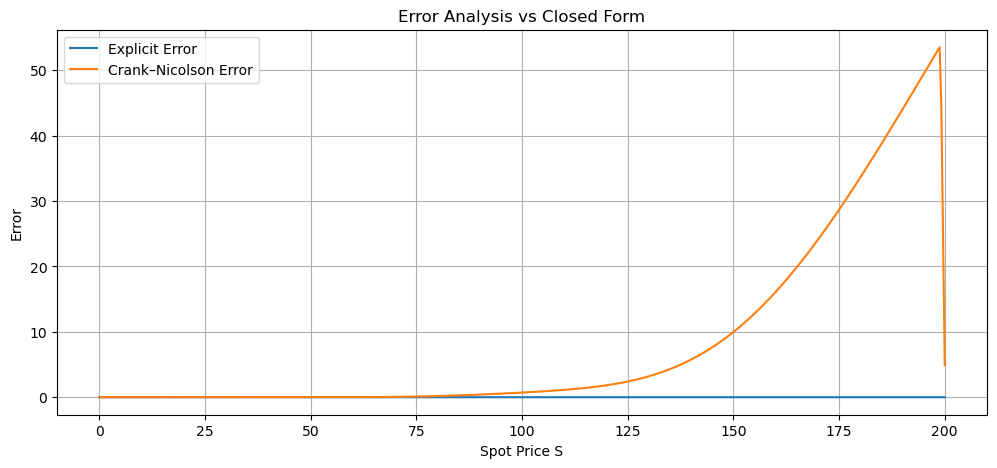

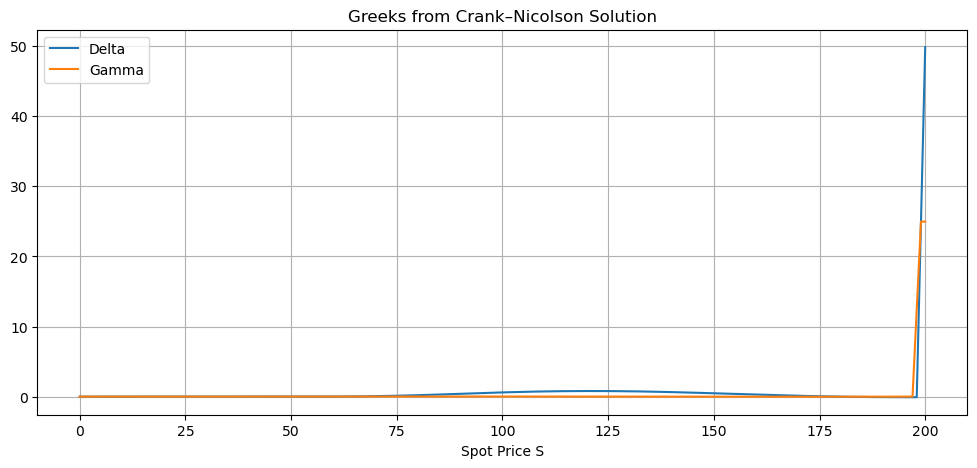

In [12]:
# PLOTS

plt.figure(figsize=(12,5))
plt.plot(S_vals, analytic, label="Black-Scholes Closed Form")
plt.plot(S_exp, V_exp, label="Explicit FDM")
plt.plot(S_cn, V_cn, label="Crank–Nicolson FDM")
plt.title("European Call Pricing: FDM vs Closed Form")
plt.xlabel("Spot Price S")
plt.ylabel("Option Price")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(S_vals, analytic - V_exp_interp, label="Explicit Error")
plt.plot(S_vals, analytic - V_cn_interp, label="Crank–Nicolson Error")
plt.title("Error Analysis vs Closed Form")
plt.xlabel("Spot Price S")
plt.ylabel("Error")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(S_cn, delta, label="Delta")
plt.plot(S_cn, gamma, label="Gamma")
plt.title("Greeks from Crank–Nicolson Solution")
plt.xlabel("Spot Price S")
plt.legend()
plt.grid()
plt.show()